# Train a single-task regression model from scratch

In this tutorial, we train a single-task convolutional regression model to predict total coverage over ATAC-seq peaks, starting from an ATAC-seq fragment file.

In [1]:
import os
import numpy as np
import pandas as pd
import torch

## Set experiment parameters

In [2]:
experiment='tutorial_3'
if not os.path.exists(experiment):
    os.makedirs(experiment)

## Peak and fragment files

We downloaded pseudobulk scATAC data for human microglia from Corces et al. (2020): `https://www.nature.com/articles/s41588-020-00721-x`. Here, we use the `grelu.resources` module to download the fragment file and peak file from the model zoo:

In [3]:
import grelu.resources

/opt/conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Download these datasets into local directories

fragment_file_dir = grelu.resources.get_artifact(
    project='microglia-scatac-tutorial', name='fragment_file').download()

peak_file_dir = grelu.resources.get_artifact(
    project='microglia-scatac-tutorial', name='peak_file').download()

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: anony-mouse-180959755991866352. Use `wandb login --relogin` to force relogin
wandb: Downloading large artifact fragment_file:latest, 2203.42MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:4.1
wandb:   1 of 1 files downloaded.  


In [5]:
# Paths to files
frag_file = os.path.join(fragment_file_dir, "Microglia_full.bed")
peak_file = os.path.join(peak_file_dir, "Microglia_full_peaks.narrowPeak")

## Set parameters

In [6]:
seq_len=2114 # Length of the input sequence
label_len=1000 # Length over which we calculate total coverage
val_chroms=["chr10"]
test_chroms=["chr11"]
genome="hg38"

## Read peak file

We read peak coordinates from the narrowPeak file.

In [7]:
import grelu.io.bed

peaks = grelu.io.bed.read_narrowpeak(peak_file)
peaks.tail(3)

,chrom,start,end,name,score,strand,signal,pvalue,qvalue,summit
83316,chrY,56870777,56870983,Microglia_full_peak_83318,94,.,3.83352,11.58170,9.41381,116
83317,chrY,56873629,56873811,Microglia_full_peak_83319,49,.,3.01171,7.02098,4.99754,105
83318,chrY,56874075,56874225,Microglia_full_peak_83320,42,.,2.86533,6.19767,4.20704,17


## Summit-center peaks

We extract the genomic coordinates for the 2114 bases surrounding the summit of each peak.

In [8]:
import grelu.data.preprocess

peaks = grelu.data.preprocess.extend_from_coord(
    peaks,
    seq_len=seq_len,
    center_col="summit"
)
peaks.tail(3)

,chrom,start,end
83316,chrY,56869836,56871950
83317,chrY,56872677,56874791
83318,chrY,56873035,56875149


## Filter peaks

We filter the peaks to include only those within autosomes. You can also use "autosomesX" or "autosomesXY" to include sex chromosomes.

In [9]:
peaks = grelu.data.preprocess.filter_chromosomes(peaks, 'autosomes')

Keeping 80823 intervals


We drop peaks that are close to ENCODE hg38 blacklist regions.

In [10]:
peaks = grelu.data.preprocess.filter_blacklist(
    peaks,
    genome=genome,
    window=50 # Remove peaks if they are within 50 bp of a blacklist region
)

Keeping 80028 intervals


## Get GC matched negative regions

To ensure that the model also learns to recognize regions that are not peaks, we will include a set of "negative" (non-peak) regions with similar GC content to the peaks.

In [11]:
negatives = grelu.data.preprocess.get_gc_matched_intervals(
    peaks,
    binwidth=0.02, # resolution of measuring GC content
    genome=genome,
    chroms="autosomes", # negative regions will also be chosen from autosomes
    #gc_bw_file='gc_hg38_2114.bw',
    blacklist=genome, # negative regions overlapping the blacklist will be dropped
    seed=0,
)
negatives.head(3)

Extracting matching intervals
Filtering blacklist
Keeping 77148 intervals


,chrom,start,end
39048,chr1,801206,803320
13936,chr1,813890,816004
20216,chr1,858284,860398


We can visualize a histogram of GC content in the peaks and negative regions to verify that they are similar.

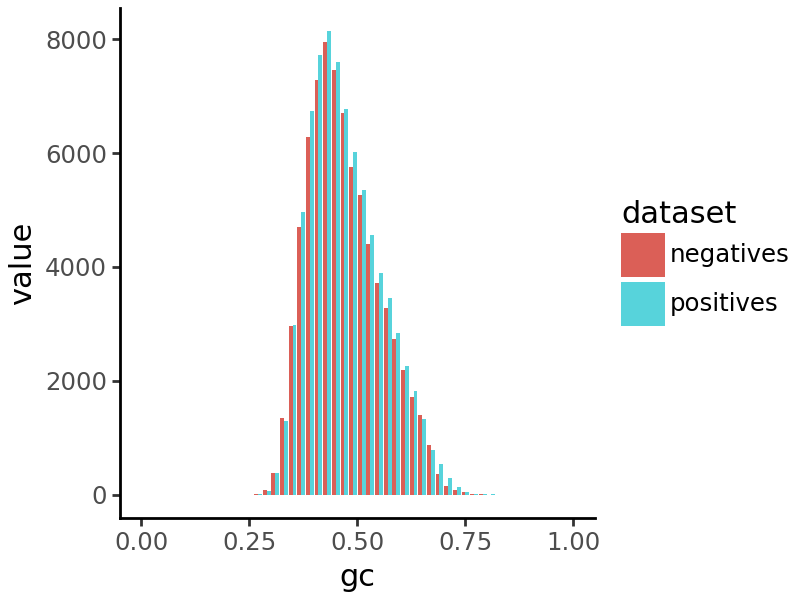

In [12]:
import grelu.visualize
grelu.visualize.plot_gc_match(
    positives=peaks, negatives=negatives, binwidth=0.02, genome="hg38", figsize=(4, 3)
)

## Combine peaks and negative regions

The full dataset includes both peaks and negative regions.

In [13]:
regions = pd.concat([peaks, negatives])
len(regions)

157176

## Make BigWig file

We convert the ATAC-seq fragment file into a bigWig file which contains the number of Tn5 insertions at each position.

In [16]:
bw_file = grelu.data.preprocess.make_insertion_bigwig(
    frag_file = frag_file,
    plus_shift=0,
    minus_shift=1, # This corrects the +4/-5 Tn5 shift to a +4/-4 shift
    genome=genome,
    chroms="autosomes", # The output bigWig file contains coverage over autosomes.
)

Making bedgraph file
cat /code/gReLU/docs/tutorials/artifacts/fragment_file:v0/Microglia_full.bed | awk -v OFS="\t" '{print $1,$2+0,$3,1000,0,"+";
    print $1,$2,$3+1,1000,0,"-"}' | sort -k1,1 | grep -e ^chr1 -e ^chr2 -e ^chr3 -e ^chr4 -e ^chr5 -e ^chr6 -e ^chr7 -e ^chr8 -e ^chr9 -e ^chr10 -e ^chr11 -e ^chr12 -e ^chr13 -e ^chr14 -e ^chr15 -e ^chr16 -e ^chr17 -e ^chr18 -e ^chr19 -e ^chr20 -e ^chr21 -e ^chr22  | bedtools genomecov -bg -5 -i stdin -g /root/.local/share/genomes/hg38/hg38.fa.sizes | bedtools sort -i stdin > ./Microglia_full.bedGraph
Making bigWig file
bedGraphToBigWig ./Microglia_full.bedGraph /root/.local/share/genomes/hg38/hg38.fa.sizes ./Microglia_full.bw
Deleting temporary files


## Split data by chromosome

We now split the dataset by chromosome to create separate datasets for training, validation and testing.

In [14]:
train, val, test = grelu.data.preprocess.split(
    regions, val_chroms=val_chroms, test_chroms=test_chroms)

Selecting training samples
Keeping 140654 intervals


Selecting validation samples
Keeping 8115 intervals


Selecting test samples
Keeping 8407 intervals
Final sizes: train: (126394, 3), val: (699, 3), test: (791, 3)


## Make labeled datasets

We now make pytorch dataset objects in order to load paired sequences and coverage values from the genome and the bigWig file. We use the `BigWigSeqDataset` class.

We first make the training dataset. To increase model robustness we use several forms of data augmentation here: `rc=True` (reverse complementing the input sequence), `max_seq_shift=2` (shifting the coordinates of the input sequence by upto 2 bp in either direction; also known as jitter), and `max_pair_shift=20` (shifting both the input sequence and the region for which to calculate coverage by upto 20 bp in either direction).

Further, we use `label_aggfunc="sum"` which means that the label will be the summed coverage over the central region of the interval.

In [15]:
import grelu.data.dataset

In [18]:
train_ds = grelu.data.dataset.BigWigSeqDataset(
    intervals = train,
    bw_files=[bw_file],
    label_len=label_len,
    label_aggfunc="sum",
    rc=True, # reverse complement
    max_seq_shift=2, # Shift the sequence
    max_pair_shift=20, # Shift both sequence and label
    augment_mode="random",
    seed=0,
    genome=genome,
)

We do not apply any augmentations to the validation and test datasets (although it is possible to do so).

In [19]:
val_ds = grelu.data.dataset.BigWigSeqDataset(
    intervals = val,
    bw_files=[bw_file],
    label_len=label_len,
    label_aggfunc="sum", 
    genome=genome,
)

test_ds = grelu.data.dataset.BigWigSeqDataset(
    intervals = test,
    bw_files=[bw_file],
    label_len=label_len,
    label_aggfunc="sum",
    genome=genome,
)

len(train_ds), len(val_ds), len(test_ds)

(126394, 699, 791)

## Build model

In [21]:
model_params = {
    'model_type':'DilatedConvModel',
    'crop_len':(seq_len-label_len)//2,
    'n_tasks':1,
    'channels':512,
    'n_conv':8,
}

import grelu.lightning
model = grelu.lightning.LightningModel(model_params)

## Train model

In [22]:
# See the tutorial_3 folder for logs.
trainer = model.train_on_dataset(
    train_ds, 
    val_ds,
    task='regression',
    loss='poisson', # Poisson loss. Other regression loss functions are "mse" and "poisson_multinomial"
    logger='csv',
    lr=1e-4,
    batch_size=256,
    max_epochs=10,
    devices=0,
    num_workers=16,
    save_dir=experiment,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.22it/s]


/opt/conda/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The variance of predictions or target is close to zero. This can cause instability in Pearson correlationcoefficient, leading to wrong results. Consider re-scaling the input if possible or computing using alarger dtype (currently using torch.float32).


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val_loss          │      1526.3466796875      │
│          val_mse          │       229090.453125       │
│        val_pearson        │    0.5063508152961731     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | model        | DilatedConvModel | 5.6 M  | train
1 | transform    | Identity         | 0      | train
2 | loss         | PoissonNLLLoss   | 0      | train
3 | val_metrics  | MetricCollection | 0      | train
4 | test_metrics | MetricCollection | 0      | train
----------------------------------------------------------
5.6 M     Trainable params
0         Non-trainable params
5.6 M     Total params
22.211    Total estimated model params size (MB)
118       Modules in train mode
0         Modules in eval mode


/opt/conda/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The variance of predictions or target is close to zero. This can cause instability in Pearson correlationcoefficient, leading to wrong results. Consider re-scaling the input if possible or computing using alarger dtype (currently using torch.float32).


Epoch 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 494/494 [02:12<00:00,  3.73it/s, v_num=0, train_loss_step=165.0]
Validation: |                                                                                                                                                                                                        | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 494/494 [02:12<00:00,  3.72it/s, v_num=0, train_loss_step=207.0, train_loss_epoch=201.0]
Validation: |                                                                                                                                                                                                        | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████████████████████████████████████

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



## Load the best model version

In [23]:
best_checkpoint = trainer.checkpoint_callback.best_model_path
print(best_checkpoint)

tutorial_3/2025_14_02_19_45/version_0/checkpoints/epoch=8-step=4446.ckpt


In [24]:
model = grelu.lightning.LightningModel.load_from_checkpoint(best_checkpoint)

## Evaluate model

We now evaluate the model's performance on the test dataset.

In [25]:
test_metrics = model.test_on_dataset(
    test_ds,
    batch_size=256,
    devices=0,
    num_workers=8
)

test_metrics

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 0: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.87it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    116.37079620361328     │
│         test_mse          │      102250.7578125       │
│       test_pearson        │    0.6922657489776611     │
└───────────────────────────┴───────────────────────────┘

,test_mse,test_pearson
Microglia_full,102250.757812,0.692266


## Run inference on held out sequences

We can now get the predicted total coverage for each sequence in the test set.

In [26]:
preds = model.predict_on_dataset(
    test_ds, devices=0, num_workers=8
    )
preds.shape

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 12.41it/s]


(791, 1, 1)

We can visualize a scatter plot of predicted vs. true coverage values

/tmp/ipykernel_2596838/723997811.py:3: RuntimeWarning: divide by zero encountered in log
/opt/conda/lib/python3.11/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_pointdensity : Removed 2 rows containing non-finite values.


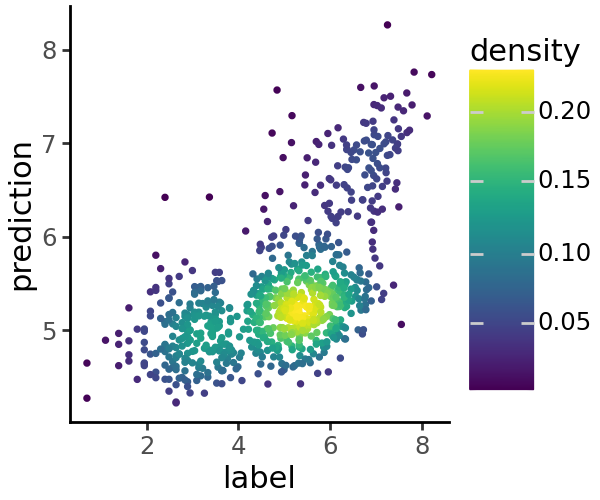

In [27]:
grelu.visualize.plot_pred_scatter(
    preds=np.log(preds),
    labels=np.log(test_ds.get_labels()),
    density=True, # Color points by local density
    figsize=(3, 2.5), # width, height
    size=.5
)

## Perform a marginalization experiment

See tutorial 2 for an example of interpreting the model using ISM and TF-modisco, which discovers motifs that contribute to the model's predictions. Here, we instead study the learned effect of a single specific motif.

To understand the effect of the `SPI1.H12CORE.0.P.B` motif in HOCOMOCO v12, we perform a marginalization experiment. In this, we take the `SPI1.H12CORE.0.P.B` motif and insert it into shuffled background sequences, and compare the predictions of the model before and after inserting this motif.

First, we read this motif from the MEME file and extract the consensus sequence.

In [22]:
import grelu.io.motifs
import grelu.interpret.motifs
motifs = grelu.io.motifs.read_meme_file("hocomoco_v12", names=["SPI1.H12CORE.0.P.B"])
patterns = grelu.interpret.motifs.motifs_to_strings(motifs)

print(patterns)

['AAAAGAGGAAGTGA']


We will select some peaks from the test set to shuffle and use as the background.

In [23]:
result = grelu.interpret.motifs.marginalize_patterns(
    model=model,
    patterns=patterns,
    seqs = test.head(100), # First 100 peaks
    genome = "hg38",
    devices = 0,
    num_workers = 8,
    batch_size = 512,
    n_shuffles = 1, # Each peak will be shuffled 1 time, conserving dinucleotide frequency
    seed = 0,
    compare_func = "subtract", # Return the change in the prediction after inserting the pattern
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.85it/s]


In [24]:
result.squeeze().mean()

7.7413588

We see that on average, inserting this motif into a shuffled peak sequence increases the coverage predicted by the model.